In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
%tensorflow_version 2.x

## Download Packages

In [3]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 3.7MB/s 
     |████████████████████████████████| 1.1MB 16.0MB/s 
     |████████████████████████████████| 3.0MB 27.8MB/s 
     |████████████████████████████████| 1.1MB 58.3MB/s 
     |████████████████████████████████| 890kB 62.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=2b1e85f195d127cd97532cabd3dd852dee4d0d42bf809c423bc14418c962406c
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=bd4b18d0fdd309da8a3c10df0b3faf50bffd47d9bb58203b37292c74dc1378b3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


## Import Packages

In [46]:
from os import listdir
import string
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D, AveragePooling1D
from tensorflow.keras.layers import Activation, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils  import plot_model, to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.models import Model
from tensorflow_addons.layers import WeightNormalization
from tensorflow_addons.optimizers import AdamW, Lookahead

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Helper Functions

In [48]:
def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Extract and load source datasets

In [ ]:
! unzip '/content/drive/My Drive/Colab Notebooks/Programming Language Detection/Experiment-3/Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Train/Rust/aks-test-for-primes-2.rust  
  inflating: Dataset/Train/Rust/align-columns.rust  
  inflating: Dataset/Train/Rust/aliquot-sequence-classifications.rust  
  inflating: Dataset/Train/Rust/almost-prime.rust  
  inflating: Dataset/Train/Rust/amb.rust  
  inflating: Dataset/Train/Rust/amicable-pairs.rust  
  inflating: Dataset/Train/Rust/anagrams-1.rust  
  inflating: Dataset/Train/Rust/anagrams-2.rust  
  inflating: Dataset/Train/Rust/anagrams-deranged-anagrams.rust  
  inflating: Dataset/Train/Rust/animation.rust  
  inflating: Dataset/Train/Rust/anonymous-recursion.rust  
  inflating: Dataset/Train/Rust/append-a-record-to-the-end-of-a-text-file.rust  
  inflating: Dataset/Train/Rust/apply-a-callback-to-an-array.rust  
  inflating: Dataset/Train/Rust/arbitrary-precision-integers--included-.rust  
  inflating: Dataset/Train/Rust/arena-storage-pool.rust  
  inflating: Dataset/Train/Rust/arithmetic-complex.rus

In [ ]:
train_data = {}
for folder in listdir('Dataset/Train'):
    for idx, file in enumerate(listdir('Dataset/Train/' + folder)):
        print("{} | {} -> {}".format(idx, folder, file))
        f = open('Dataset/Train/' + folder + "/" + file, "r")
        train_data[folder + "_" + str(idx)] = f.read()
        f.close()

Streaming output truncated to the last 5000 lines.
394 | Racket -> monte-carlo-methods-1.rkt
395 | Racket -> sorting-algorithms-counting-sort-2.rkt
396 | Racket -> string-concatenation.rkt
397 | Racket -> loops-while-1.rkt
398 | Racket -> executable-library-1.rkt
399 | Racket -> program-name.rkt
400 | Racket -> levenshtein-distance.rkt
401 | Racket -> sorting-algorithms-bubble-sort-2.rkt
402 | Racket -> substring.rkt
403 | Racket -> minesweeper-game.rkt
404 | Racket -> apply-a-callback-to-an-array.rkt
405 | Racket -> sierpinski-triangle.rkt
406 | Racket -> bitmap-histogram.rkt
407 | Racket -> van-der-corput-sequence-3.rkt
408 | Racket -> higher-order-functions.rkt
409 | Racket -> textonyms.rkt
410 | Racket -> number-reversal-game.rkt
411 | Racket -> set-of-real-numbers.rkt
412 | Racket -> longest-increasing-subsequence.rkt
413 | Racket -> start-from-a-main-routine.rkt
414 | Racket -> rsa-code.rkt
415 | Racket -> roots-of-a-function-4.rkt
416 | Racket -> pinstripe-printer.rkt
417 | Rack

In [ ]:
test_data = {}
fileset = {}
for idx, file in enumerate(listdir('Dataset/Test')):
    print("{} | {}".format(idx, file))
    f = open('Dataset/Test/' + file, "r")
    test_data[str(idx)] = f.read()
    fileset[str(idx)] = file
    f.close()

0 | zero-to-the-zero-power.m
1 | zeckendorf-number-representation-1.rexx
2 | variables-3.jq
3 | word-wrap-2.ada
4 | wireworld.julia
5 | walk-a-directory-recursively-1.groovy
6 | yahoo--search-interface.math
7 | yahoo--search-interface.d
8 | video-display-modes.go
9 | gui-component-interaction.ada
10 | zeckendorf-arithmetic.rkt
11 | walk-a-directory-non-recursively.c
12 | walk-a-directory-non-recursively-1.psh
13 | 24-game-2.py
14 | visualize-a-tree-1.py
15 | walk-a-directory-recursively-4.groovy
16 | zig-zag-matrix-2.zkl
17 | voronoi-diagram.js
18 | xml-output-3.go
19 | twelve-statements.clj
20 | yin-and-yang.awk
21 | yahoo--search-interface.kotlin
22 | variable-size-get.sh
23 | world-cup-group-stage.erl
24 | zeckendorf-number-representation-1.py
25 | fork.d
26 | write-to-windows-event-log.julia
27 | window-creation-1.d
28 | van-der-corput-sequence.math
29 | write-to-windows-event-log-2.rexx
30 | variadic-function-1.swift
31 | xml-xpath-2.go
32 | yin-and-yang.math
33 | voronoi-diagram.

## Data Preprocessing

In [ ]:
# Prepare the training data
train_df = pd.DataFrame(list(train_data.items()), 
                        columns=['prog_lang', 'code_snippet'])
train_df['ID'] = train_df['prog_lang'].apply(lambda x: x.split('_')[1])
train_df['prog_lang'] = train_df['prog_lang'].apply(lambda x: x.split('_')[0])

# Get rid of '\n' from whitespace
train_df['code_snippet'] = train_df['code_snippet'].apply(lambda x: x.replace('\n', ' '))
print(train_df.shape)
train_df.head()

(30969, 3)


,prog_lang,code_snippet,ID
0,Swift,var block = Block() let message:[UInt32] = [ 0...,0
1,Swift,func F(n: Int) -> Int { return n == 0 ? 1 : ...,1
2,Swift,import Foundation func soeTreeFoldingOdds() -...,2
3,Swift,"typealias FourBit = (Int, Int, Int, Int) func...",3
4,Swift,"import Foundation let shift : [UInt32] = [7, ...",4


In [ ]:
# Prepare the testing data
test_df = pd.DataFrame(list(test_data.items()), 
                       columns=['ID', 'code_snippet'])

# Get rid of '\n' from whitespace
test_df['code_snippet'] = test_df['code_snippet'].apply(lambda x: x.replace('\n', ' '))
print(test_df.shape)
test_df.head()

(1370, 2)


,ID,code_snippet
0,0,"0^0 complex(0,0)^0"
1,1,/* REXX **************************************...
2,2,def test: $x; test
3,3,package body Word_Wrap is procedure Push_W...
4,4,"function surround2D(b, i, j) h, w = size(b..."


In [ ]:
fileset_df = pd.DataFrame(list(fileset.items()), columns=['ID', 'File_Name'])
fileset_df.to_excel('/content/drive/My Drive/Colab Notebooks/Programming Language Detection/Experiment-3/Prediction_Fileset.xlsx', index=False)

### Prepare true-labels for model training

In [ ]:
lang_map = {
     'Ada': 0
    ,'AWK': 1
    ,'C': 2
    ,'C++': 3
    ,'Clojure': 4
    ,'D': 5
    ,'Erlang': 6
    ,'Fortran': 7
    ,'Go': 8
    ,'Groovy': 9
    ,'Haskell': 10
    ,'J': 11
    ,'Java': 12
    ,'JavaScript': 13
    ,'Julia': 14
    ,'Lua': 15
    ,'Mathematica': 16
    ,'MATLAB': 17
    ,'Perl': 18
    ,'PHP': 19
    ,'PowerShell': 20
    ,'Python': 21
    ,'R': 22
    ,'REXX': 23
    ,'Ruby': 24
    ,'Rust': 25
    ,'Scala': 26
    ,'Smalltalk': 27
    ,'Swift': 28
    ,'UNIX-Shell': 29
    ,'Tcl': 30
    ,'Zkl': 31
    ,'Jq': 32
    ,'Racket': 33
    ,'Kotlin': 34
}

In [ ]:
# Encode "prog_lang" field
train_df['prog_lang'] = train_df['prog_lang'].map(lang_map)
Ytrain = np.array([train_df['prog_lang'].values]).T
train_df.drop(['prog_lang'], inplace=True, axis=1)
print("Ytrain: {}".format(Ytrain.shape))
train_df.head()

Ytrain: (30969, 1)


,code_snippet,ID
0,var block = Block() let message:[UInt32] = [ 0...,0
1,func F(n: Int) -> Int { return n == 0 ? 1 : ...,1
2,import Foundation func soeTreeFoldingOdds() -...,2
3,"typealias FourBit = (Int, Int, Int, Int) func...",3
4,"import Foundation let shift : [UInt32] = [7, ...",4


### Calculate class-weights

In [ ]:
temp_df = pd.DataFrame(Ytrain, columns=['target'])
temp_df = temp_df.groupby(['target']).size().reset_index().rename(columns={0:'count'})
total_count = np.sum(temp_df['count'].values)
temp_df['class%'] = (temp_df['count'] / total_count) * 100
lowest_pct = min(temp_df['class%'])
temp_df['class_weight'] = lowest_pct / temp_df['class%']
class_weight = temp_df[['target', 'class_weight']].to_dict()['class_weight']
class_weight

{0: 0.40419161676646703,
 1: 0.8940397350993378,
 2: 0.37121906507791014,
 3: 0.4576271186440678,
 4: 0.5688202247191011,
 5: 0.4196891191709844,
 6: 0.8148893360160965,
 7: 0.5465587044534413,
 8: 0.3842504743833017,
 9: 0.5852601156069364,
 10: 0.2919971160778659,
 11: 0.22314049586776857,
 12: 0.3986220472440945,
 13: 0.3534031413612565,
 14: 0.42143600416233085,
 15: 0.6887755102040816,
 16: 0.45100222717149213,
 17: 0.7803468208092484,
 18: 0.34292972057578325,
 19: 0.826530612244898,
 20: 0.5205655526992288,
 21: 0.25471698113207547,
 22: 0.6318252730109203,
 23: 0.3678474114441416,
 24: 0.3795688847235239,
 25: 0.7232142857142857,
 26: 0.4470198675496689,
 27: 1.0,
 28: 0.8402489626556016,
 29: 0.7670454545454545,
 30: 0.36225402504472265,
 31: 0.3974484789008832,
 32: 0.40499999999999997,
 33: 0.4267650158061117,
 34: 0.5532786885245901}

### Feature Engineering

In [ ]:
combined_df = train_df.append(test_df, sort=False, ignore_index=True)
combined_df.head()

,code_snippet,ID
0,var block = Block() let message:[UInt32] = [ 0...,0
1,func F(n: Int) -> Int { return n == 0 ? 1 : ...,1
2,import Foundation func soeTreeFoldingOdds() -...,2
3,"typealias FourBit = (Int, Int, Int, Int) func...",3
4,"import Foundation let shift : [UInt32] = [7, ...",4


In [ ]:
# Number of words in the "code_snippet" field
combined_df["code_snippet_num_words"] = combined_df["code_snippet"].apply(lambda x: len(str(x).split()))

# Number of unique words in the "code_snippet" field
combined_df["code_snippet_num_unique_words"] = combined_df["code_snippet"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the "code_snippet" field
combined_df["code_snippet_num_chars"] = combined_df["code_snippet"].apply(lambda x: len(str(x)))

# Number of stopwords in the "code_snippet" field
stop = stopwords.words('english')
combined_df["code_snippet_num_stopwords"] = combined_df["code_snippet"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))

# Number of punctuations in the "code_snippet" field
combined_df["code_snippet_num_punctuations"] = combined_df['code_snippet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of Hashtags in the "code_snippet" field
combined_df['code_snippet_num_hastags'] = combined_df['code_snippet'].apply(lambda x: len([x for x in str(x).split() if x.startswith('#')]))

# Number of @ in the "code_snippet" field
combined_df['code_snippet_num_@'] = combined_df['code_snippet'].apply(lambda x: len([x for x in str(x).split() if x.startswith('@')]))

# Number of $ in the "code_snippet" field
combined_df['code_snippet_num_$'] = combined_df['code_snippet'].apply(lambda x: len([x for x in str(x).split() if x.startswith('$')]))

# Number of numerics in the "code_snippet" field
combined_df['code_snippet_num_numerics'] = combined_df['code_snippet'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))

# Number of upper case words in the "code_snippet" field
combined_df["code_snippet_num_words_upper"] = combined_df["code_snippet"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words in the "code_snippet" field
combined_df["code_snippet_num_words_title"] = combined_df["code_snippet"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#### Tf-IDF Vectorization

In [ ]:
# TF-IDF encoding for "code_snippet" field
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(1, 10), max_features=500)
features = tfidf.fit_transform(combined_df.code_snippet).toarray()
features_df = pd.DataFrame(features, columns=tfidf.get_feature_names())
print(features_df.shape)
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)

(32339, 500)


#### Roberta Base Embedding

In [ ]:
roberta_embedder = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')
roberta_sentence_embeddings = roberta_embedder.encode(combined_df.code_snippet.values.tolist(), 
                                                      batch_size=64, show_progress_bar=True)

100%|██████████| 461M/461M [00:19<00:00, 24.0MB/s]


In [ ]:
features_df = pd.DataFrame(roberta_sentence_embeddings)
print(features_df.shape)
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)
combined_df.head()

(32339, 768)


,code_snippet,ID,code_snippet_num_words,code_snippet_num_unique_words,code_snippet_num_chars,code_snippet_num_stopwords,code_snippet_num_punctuations,code_snippet_num_hastags,code_snippet_num_@,code_snippet_num_$,code_snippet_num_numerics,code_snippet_num_words_upper,code_snippet_num_words_title,,"""",#,$,',(,),*,*,+,+,-,->,->,.,/,/*,//,//,0,0,1,1,2,3,:,<,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,var block = Block() let message:[UInt32] = [ 0...,0,41,26,401,0,87,0,0,0,1,0,1,0.314767,0.013638,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.221918,0.019795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.184759,-0.500578,0.103705,0.235247,0.617674,-0.320806,0.482177,-0.563874,-0.080396,0.015818,0.167171,-0.155904,0.765779,-1.444940,1.579151,-0.239134,0.157168,0.847859,0.211926,0.259744,-0.120785,0.578232,0.285009,0.750177,0.665574,-0.452650,0.180542,0.051953,-0.702505,0.152763,-0.283443,-0.804622,-0.653512,-0.005083,0.414833,0.487890,-0.173699,-0.913590,-0.027941,0.622969
1,func F(n: Int) -> Int { return n == 0 ? 1 : ...,1,52,26,224,6,64,0,0,0,4,0,4,0.539819,0.036883,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.080537,0.067470,0.067845,0.000000,0.0,0.0,0.0,0.0,0.100026,0.080300,0.017114,0.025366,0.000000,0.000000,0.050382,0.000000,...,-0.243202,-0.414838,0.598267,0.100589,-0.331053,-0.283915,0.312902,1.556794,0.290269,-0.096247,-0.257868,0.526631,0.470600,-0.972245,-0.237513,-0.502860,-0.156333,0.580706,-0.484568,-0.200768,-0.839747,0.719754,1.025455,-0.056121,-0.033544,-1.232080,-0.177047,-0.072002,0.539130,0.098789,0.313587,-0.374461,-0.485964,0.388654,1.029368,-0.057366,0.122737,0.449165,0.079984,0.978672
2,import Foundation func soeTreeFoldingOdds() -...,2,350,156,2198,25,460,0,1,3,6,6,9,0.546993,0.008329,0.0,0.012449,0.0,0.027165,0.0,0.007657,0.008927,0.019784,0.018213,0.036373,0.055866,0.056176,0.013442,0.0,0.0,0.0,0.0,0.000000,0.000000,0.020612,0.007638,0.009683,0.000000,0.000000,0.017570,...,-0.930224,0.210898,-0.249307,-1.062228,0.772916,-1.997384,0.220367,-0.219784,-0.339162,-0.399864,-0.377614,0.570070,-0.262928,-0.647025,1.910747,-0.107700,0.145908,0.191054,-0.083105,0.435998,0.395738,1.312085,0.606655,0.372591,-0.276985,-0.549674,0.209085,-0.304591,-0.498092,0.287224,-0.234994,-0.690625,-0.431986,0.051049,1.138898,0.423553,-0.930001,-2.105546,-0.182925,0.008834
3,"typealias FourBit = (Int, Int, Int, Int) func...",3,126,66,711,2,154,0,0,0,0,0,14,0.510849,0.000000,0.0,0.000000,0.0,0.096100,0.0,0.000000,0.000000,0.008554,0.009450,0.023590,0.039526,0.039746,0.000000,0.0,0.0,0.0,0.0,0.015626,0.000000,0.026736,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.386404,-0.995812,-0.003525,-0.259086,0.300287,-0.488294,0.250620,-0.500220,0.534539,-0.327018,-1.212738,0.533943,0.511179,-1.189476,1.767370,-0.506636,0.053503,-0.823575,-0.476693,-0.382528,-0.139945,0.706591,1.723579,0.542719,0.963892,-1.014707,0.235351,0.079704,-0.295064,-0.157270,0.261290,-0.240005,-0.908485,0.146558,1.588454,0.470982,-0.286769,-0.179856,-0.955425,0.135170
4,"import Foundation let shift : [UInt32] = [7, ...",4,339,165,2581,22,369,0,0,1,7,0,2,0.556803,0.026260,0.0,0.004361,0.0,0.051909,0.0,0.012071,0.014073,0.020792,0.019141,0.006371,0.010675,0.010734,0.009418,0.0,0.0,0.0,0.0,0.041147,0.008470,0.029786,0.000000,0.016961,0.004068,0.023914,0.003693,...,-0.466301,-0.630697,0.201764,-0.088583,-0.292516,-0.564125,0.653673,0.213779,0.257834,-0.910744,-0.184232,0.201847,0.435369,-1.193329,1.445504,-0.206687,0.422175,0.793803,0.175570,-0.336917,-0.208217,0.939383,0.756059,0.549212,-0.024642,-0.982396,-0.659514,-0.320510,-0.480871,0.130586,-0.065364,-0.765474,-0.793527,0.270742,0.331572,0.274324,0.441342,-0.863021,-0.159097,0.566530


#### BERT Base Embedding

In [ ]:
bert_embedder = SentenceTransformer('bert-base-nli-stsb-mean-tokens')
bert_sentence_embeddings = bert_embedder.encode(combined_df.code_snippet.values.tolist(), 
                                                batch_size=64, show_progress_bar=True)

100%|██████████| 405M/405M [00:17<00:00, 23.4MB/s]


In [ ]:
features_df = pd.DataFrame(bert_sentence_embeddings)
print(features_df.shape)
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)
combined_df.drop(['ID','code_snippet'], inplace=True, axis=1)
combined_df.head()

(32339, 768)


,code_snippet_num_words,code_snippet_num_unique_words,code_snippet_num_chars,code_snippet_num_stopwords,code_snippet_num_punctuations,code_snippet_num_hastags,code_snippet_num_@,code_snippet_num_$,code_snippet_num_numerics,code_snippet_num_words_upper,code_snippet_num_words_title,,"""",#,$,',(,),*,*,+,+,-,->,->,.,/,/*,//,//,0,0,1,1,2,3,:,<,=,=,...,728_y,729_y,730_y,731_y,732_y,733_y,734_y,735_y,736_y,737_y,738_y,739_y,740_y,741_y,742_y,743_y,744_y,745_y,746_y,747_y,748_y,749_y,750_y,751_y,752_y,753_y,754_y,755_y,756_y,757_y,758_y,759_y,760_y,761_y,762_y,763_y,764_y,765_y,766_y,767_y
0,41,26,401,0,87,0,0,0,1,0,1,0.314767,0.013638,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.221918,0.019795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034731,0.037324,...,0.065368,0.236344,0.304146,-0.171961,-0.307262,0.437858,0.772607,-0.400046,-0.242166,-0.584810,0.919230,-0.006232,0.367911,-0.016260,-0.738203,0.341744,0.095946,0.165240,-0.589652,0.432182,-0.051306,0.865267,0.207233,0.011367,-0.250620,-0.358179,0.503432,-0.604270,-0.008713,0.239262,0.358639,0.600106,-0.468935,-0.220965,-0.088538,0.576150,0.198817,-0.107657,-0.255487,0.557317
1,52,26,224,6,64,0,0,0,4,0,4,0.539819,0.036883,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.080537,0.067470,0.067845,0.000000,0.0,0.0,0.0,0.0,0.100026,0.080300,0.017114,0.025366,0.000000,0.000000,0.050382,0.000000,0.031308,0.000000,...,0.390242,-0.502490,0.402925,-0.072840,-0.426962,0.121167,-0.119793,-0.112054,-0.305683,-0.440627,-0.300209,0.945939,0.507762,-0.560248,-0.362940,0.013199,0.304210,-0.165304,-0.799175,0.003684,0.453262,0.919048,0.392413,0.186459,-0.032820,0.224652,0.957519,-0.543404,-0.157323,-0.488235,0.354096,0.465227,0.472055,-0.590923,0.010860,0.560458,0.302623,0.445608,-0.468501,1.155117
2,350,156,2198,25,460,0,1,3,6,6,9,0.546993,0.008329,0.0,0.012449,0.0,0.027165,0.0,0.007657,0.008927,0.019784,0.018213,0.036373,0.055866,0.056176,0.013442,0.0,0.0,0.0,0.0,0.000000,0.000000,0.020612,0.007638,0.009683,0.000000,0.000000,0.017570,0.042420,0.045588,...,-0.637129,-0.106120,0.175138,-0.580082,0.212512,0.327328,0.360880,0.171822,-0.611079,0.407185,0.085012,0.416426,0.279215,-0.127247,-0.289104,0.037894,0.290013,0.508440,-0.732031,0.188663,0.071660,0.671353,-0.290776,-0.270291,-0.139782,-0.384811,0.576053,-0.564384,-0.353222,-0.387503,0.556542,-0.045437,-0.275713,-0.187887,-0.262620,0.046566,0.419664,0.460328,-0.633256,0.978661
3,126,66,711,2,154,0,0,0,0,0,14,0.510849,0.000000,0.0,0.000000,0.0,0.096100,0.0,0.000000,0.000000,0.008554,0.009450,0.023590,0.039526,0.039746,0.000000,0.0,0.0,0.0,0.0,0.015626,0.000000,0.026736,0.000000,0.000000,0.000000,0.000000,0.000000,0.061137,0.065703,...,-0.650685,0.805701,-0.234332,-0.769832,0.414675,0.364209,-0.648941,0.179961,-0.694181,-0.342401,0.165696,0.153887,-0.371810,-0.561854,-0.531835,-0.086111,0.532726,-0.783824,-0.816267,1.118081,-0.237288,0.775154,0.555162,-0.653671,0.111055,0.291551,0.518067,-0.099117,-0.006641,-0.171027,0.085908,0.062561,-0.182430,0.513080,-0.014352,-0.099067,0.312918,0.294217,-0.303954,0.231611
4,339,165,2581,22,369,0,0,1,7,0,2,0.556803,0.026260,0.0,0.004361,0.0,0.051909,0.0,0.012071,0.014073,0.020792,0.019141,0.006371,0.010675,0.010734,0.009418,0.0,0.0,0.0,0.0,0.041147,0.008470,0.029786,0.000000,0.016961,0.004068,0.023914,0.003693,0.089164,0.095822,...,-0.623484,0.050921,-0.037872,-0.520665,-0.112279,0.412916,0.432317,0.416713,0.059523,0.147960,0.351264,0.147449,0.162320,-0.822702,-0.491668,0.077935,0.812922,0.810683,-0.053111,0.613994,0.091437,0.891309,-0.268932,-0.451927,-0.423943,-0.194427,0.561054,-0.468926,-0.182736,0.037519,-0.154675,-0.051509,-0.425773,-0.014825,0.128100,0.294092,0.401964,0.282733,-0.311099,0.971224


In [ ]:
print("Column with NaN value: {}".format(combined_df.columns[combined_df.isnull().any()].tolist()))

Column with NaN value: []


#### Create train and predict Numpy arrays

In [ ]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:30969].values
predict_x = combined_df[30969:].values

print("train_x: {}".format(train_x.shape))
print("predict_x: {}".format(predict_x.shape))

train_x: (30969, 2047)
predict_x: (1370, 2047)


In [ ]:
# Scale the train_x/predict_x arrays
scaler = MinMaxScaler().fit(train_x)
Xtrain = scaler.transform(train_x)
Xpredict = scaler.transform(predict_x)

Xtrain = np.expand_dims(Xtrain, axis=2)
Xpredict = np.expand_dims(Xpredict, axis=2)
Ytrain_oh = to_categorical(Ytrain, 35)

print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))
print("Ytrain_oh shape: {}".format(Ytrain_oh.shape))
print("Xpredict shape: {}".format(Xpredict.shape))

Xtrain shape: (30969, 2047, 1)
Ytrain shape: (30969, 1)
Ytrain_oh shape: (30969, 35)
Xpredict shape: (1370, 2047, 1)


## Save the datasets in NPZ file (for reusability)

In [ ]:
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/Programming Language Detection/Experiment-3/Prog_Lang_Dataset_NN.npz',
                    Xtrain=Xtrain, Ytrain=Ytrain, Ytrain_oh=Ytrain_oh, Xpredict=Xpredict)

## Load datasets from the NPZ file

In [9]:
processed_dataset = np.load('/content/drive/My Drive/Colab Notebooks/Programming Language Detection/Experiment-3/Prog_Lang_Dataset_NN.npz', allow_pickle=True)
Xtrain, Ytrain = processed_dataset['Xtrain'], processed_dataset['Ytrain']
Ytrain_oh, Xpredict = processed_dataset['Ytrain_oh'], processed_dataset['Xpredict']

print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))
print("Ytrain_oh shape: {}".format(Ytrain_oh.shape))
print("Xpredict shape: {}".format(Xpredict.shape))

Xtrain shape: (30969, 2047, 1)
Ytrain shape: (30969, 1)
Ytrain_oh shape: (30969, 35)
Xpredict shape: (1370, 2047, 1)


## Build and validate the model

In [27]:
def prog_lang_detect_model(input_shape, output_shape):
    
    # Input Layer
    x_input = Input(shape=(input_shape, 1))
    x = BatchNormalization()(x_input)

    # Convolutional Layers
    x = WeightNormalization(
          Conv1D(filters=16, kernel_size=5, strides=2, padding='same', 
                 activation='relu', kernel_regularizer=l2(0.001),
                 kernel_initializer=he_uniform(seed=1)))(x)
    x = BatchNormalization()(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = SpatialDropout1D(rate=0.5)(x)

    x = WeightNormalization(
          Conv1D(filters=32, kernel_size=5, strides=2, padding='same', 
                 activation='relu', kernel_regularizer=l2(0.001),
                 kernel_initializer=he_uniform(seed=1)))(x)
    x = BatchNormalization()(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = SpatialDropout1D(rate=0.5)(x)

    x = WeightNormalization(
          Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_regularizer=l2(0.001),
                 kernel_initializer=he_uniform(seed=1)))(x)
    x = BatchNormalization()(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = SpatialDropout1D(rate=0.5)(x)
    
    # Fully-connected Layers
    x = Flatten()(x)
    x = WeightNormalization(
          Dense(units=1024, activation='relu', kernel_regularizer=l2(0.001), 
                kernel_initializer=he_uniform(seed=1)))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    
    x = WeightNormalization(
          Dense(units=1024, activation='relu', kernel_regularizer=l2(0.001), 
                kernel_initializer=he_uniform(seed=1)))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    
    # Output Layer
    x = WeightNormalization(
          Dense(units=output_shape, activation='softmax', 
                kernel_initializer=he_uniform(seed=1)))(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='Prog_Lang_Detect_Model')

    return model

In [28]:
# Define the model hyperparameters
mini_batch_size = 256

# Create the model
model = prog_lang_detect_model(Xtrain.shape[1], Ytrain_oh.shape[1])
model.summary()

Model: "Prog_Lang_Detect_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2047, 1)]         0         
_________________________________________________________________
batch_normalization_158 (Bat (None, 2047, 1)           4         
_________________________________________________________________
weight_normalization_30 (Wei (None, 1024, 16)          209       
_________________________________________________________________
batch_normalization_159 (Bat (None, 1024, 16)          64        
_________________________________________________________________
average_pooling1d_17 (Averag (None, 512, 16)           0         
_________________________________________________________________
spatial_dropout1d_101 (Spati (None, 512, 16)           0         
_________________________________________________________________
weight_normalization_31 (Wei (None, 256, 32)

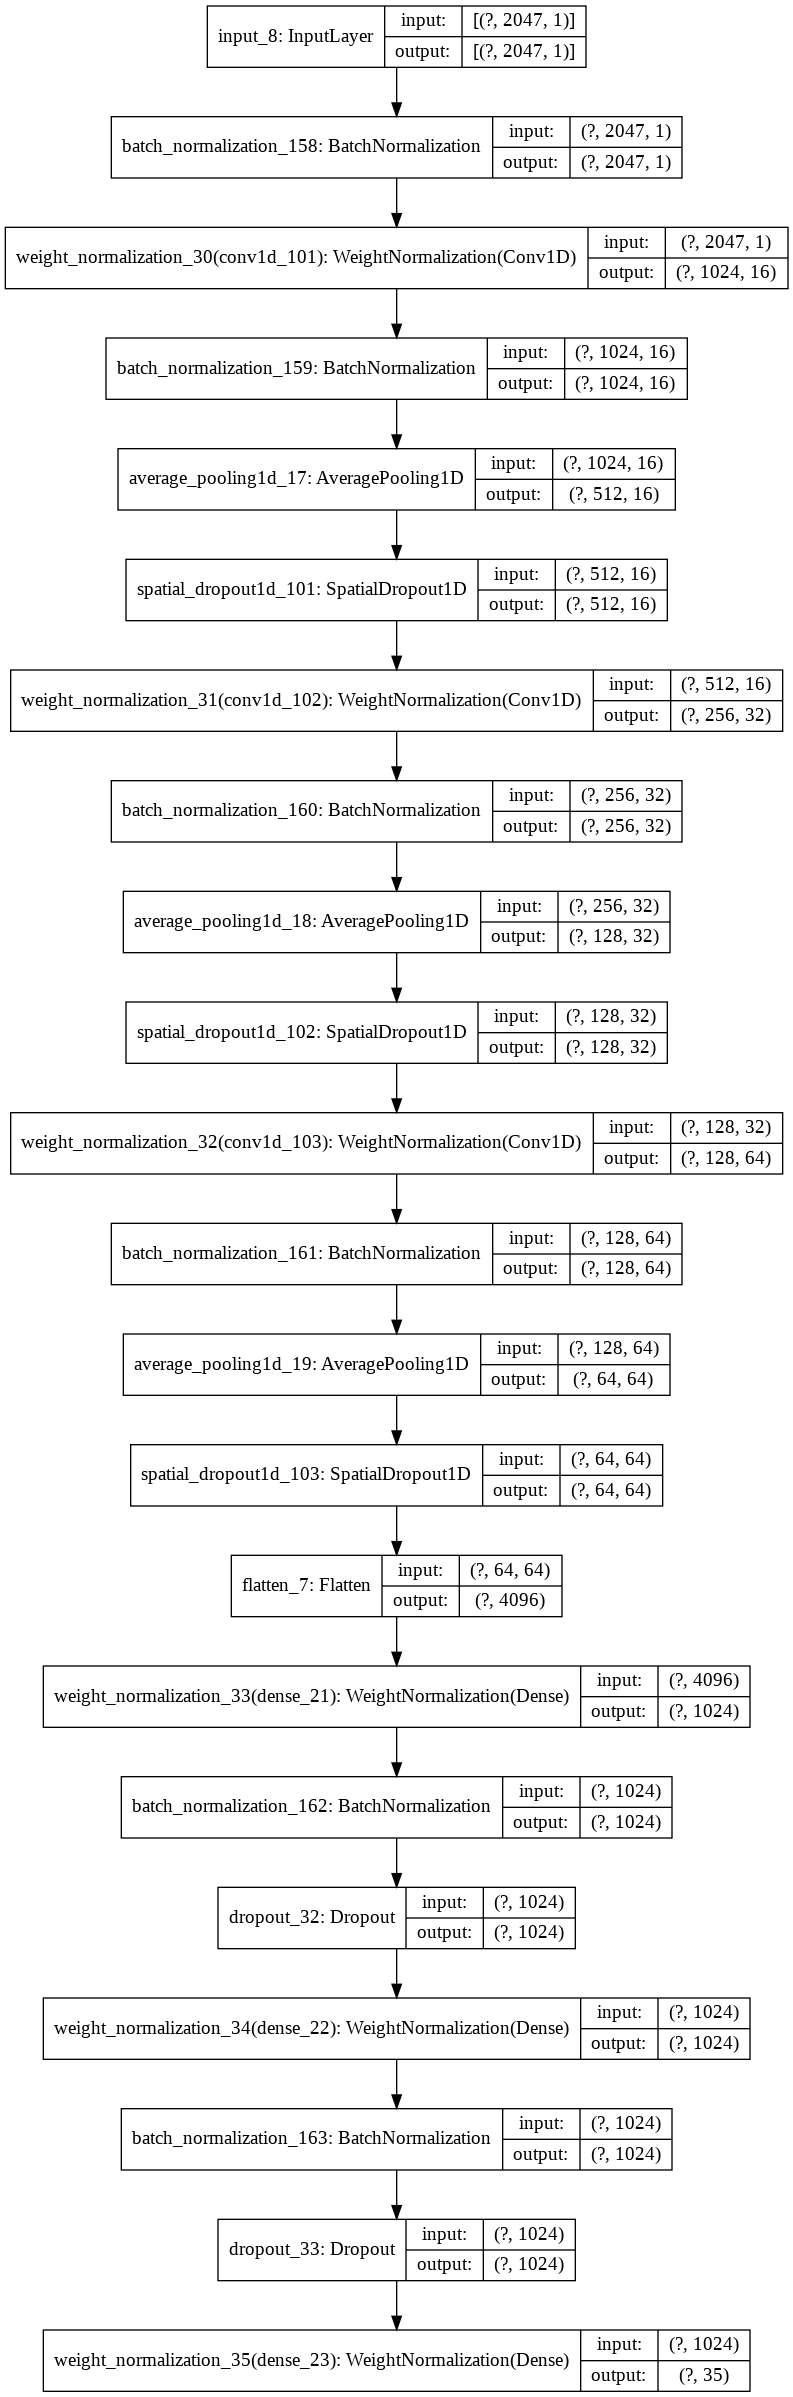

In [29]:
plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/Programming Language Detection/Experiment-3/prog_lang_detect_model.png', 
           show_shapes=True, show_layer_names=True)

In [30]:
class_weight = {0: 0.40419161676646703,
 1: 0.8940397350993378,
 2: 0.37121906507791014,
 3: 0.4576271186440678,
 4: 0.5688202247191011,
 5: 0.4196891191709844,
 6: 0.8148893360160965,
 7: 0.5465587044534413,
 8: 0.3842504743833017,
 9: 0.5852601156069364,
 10: 0.2919971160778659,
 11: 0.22314049586776857,
 12: 0.3986220472440945,
 13: 0.3534031413612565,
 14: 0.42143600416233085,
 15: 0.6887755102040816,
 16: 0.45100222717149213,
 17: 0.7803468208092484,
 18: 0.34292972057578325,
 19: 0.826530612244898,
 20: 0.5205655526992288,
 21: 0.25471698113207547,
 22: 0.6318252730109203,
 23: 0.3678474114441416,
 24: 0.3795688847235239,
 25: 0.7232142857142857,
 26: 0.4470198675496689,
 27: 1.0,
 28: 0.8402489626556016,
 29: 0.7670454545454545,
 30: 0.36225402504472265,
 31: 0.3974484789008832,
 32: 0.40499999999999997,
 33: 0.4267650158061117,
 34: 0.5532786885245901}

In [32]:
# Train the model using K-fold
counter = 0
oof_acc_score = 0
oof_f1_score = 0
y_pred_final = 0
loss_values = {}
acc_values = {}

# Define K-fold cross validation test harness
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=10)

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x_tmp, train_y_tmp = Xtrain[train], Ytrain_oh[train]
    val_x_tmp, val_y_tmp = Xtrain[val], Ytrain_oh[val]

    # Create the model
    model = prog_lang_detect_model(Xtrain.shape[1], Ytrain_oh.shape[1])

    # Compile model to configure the learning process
    model.compile(loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'],
                  optimizer=Lookahead(AdamW(lr=1e-2, 
                                            weight_decay=1e-5, 
                                            clipvalue=700), 
                                      sync_period=10))

    # Early stopping policy
    early = EarlyStopping(monitor="val_loss", mode="min", 
                          restore_best_weights=True, 
                          patience=10, verbose=0)

    # Reduce LR on plateau policy
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                                  min_lr=1e-5, patience=7, 
                                  verbose=0, mode='min')

    # Fit the model
    history = model.fit(x=train_x_tmp, y=train_y_tmp, class_weight=class_weight,
                        batch_size=mini_batch_size, epochs=275, verbose=0,
                        callbacks=[reduce_lr, early], workers=5,
                        validation_data=(val_x_tmp, val_y_tmp))
    
    # Get validation metrics
    y_pred = model.predict(val_x_tmp)
    y_pred = np.array([np.argmax(y_pred, axis=1)]).T
    y_true = np.array([np.argmax(val_y_tmp, axis=1)]).T
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)

    # Make predictions
    y_pred_final += model.predict(Xpredict)

    # Store the model loss and accuracy values
    loss_values["train_loss_"+str(counter)] = history.history['loss']
    loss_values["val_loss_"+str(counter)] = history.history['val_loss']
    acc_values["train_acc_"+str(counter)] = history.history['categorical_accuracy']
    acc_values["val_acc_"+str(counter)] = history.history['val_categorical_accuracy']

    print("Fold-{} | F1-Score: {} | Accuracy Score: {}".format(counter, f1, acc))
    oof_f1_score += f1
    oof_acc_score += acc

y_pred_final /= float(counter)
oof_f1_score /= float(counter)
oof_acc_score /= float(counter)
print("Aggregate F1-Score: {}".format(oof_f1_score))
print("Aggregate Accuracy: {}".format(oof_acc_score))

Fold-1 | F1-Score: 0.901913164276531 | Accuracy Score: 0.9016949152542373
Fold-2 | F1-Score: 0.9024054337665949 | Accuracy Score: 0.9023508137432188
Fold-3 | F1-Score: 0.9100951904326706 | Accuracy Score: 0.9098101265822784
Fold-4 | F1-Score: 0.9056955161415552 | Accuracy Score: 0.9055153707052441
Fold-5 | F1-Score: 0.9024477599465541 | Accuracy Score: 0.902124773960217
Fold-6 | F1-Score: 0.9064232267870227 | Accuracy Score: 0.9064195298372514
Fold-7 | F1-Score: 0.9038576130817506 | Accuracy Score: 0.9037070524412296
Aggregate F1-Score: 0.9046911292046685
Aggregate Accuracy: 0.9045175117890967


In [33]:
y_pred_final = np.array([np.argmax(y_pred_final, axis=1)]).T

## Validate the predictions made

In [34]:
lang_map = {
     'Ada': 0
    ,'AWK': 1
    ,'C': 2
    ,'C++': 3
    ,'Clojure': 4
    ,'D': 5
    ,'Erlang': 6
    ,'Fortran': 7
    ,'Go': 8
    ,'Groovy': 9
    ,'Haskell': 10
    ,'J': 11
    ,'Java': 12
    ,'JavaScript': 13
    ,'Julia': 14
    ,'Lua': 15
    ,'Mathematica': 16
    ,'MATLAB': 17
    ,'Perl': 18
    ,'PHP': 19
    ,'PowerShell': 20
    ,'Python': 21
    ,'R': 22
    ,'REXX': 23
    ,'Ruby': 24
    ,'Rust': 25
    ,'Scala': 26
    ,'Smalltalk': 27
    ,'Swift': 28
    ,'UNIX-Shell': 29
    ,'Tcl': 30
    ,'Zkl': 31
    ,'Jq': 32
    ,'Racket': 33
    ,'Kotlin': 34
}

In [35]:
rev_lang_map = {
     0: 'Ada'
    ,1: 'AWK'
    ,2: 'C'
    ,3: 'C++'
    ,4: 'Clojure'
    ,5: 'D'
    ,6: 'Erlang'
    ,7: 'Fortran'
    ,8: 'Go'
    ,9: 'Groovy'
    ,10: 'Haskell'
    ,11: 'J'
    ,12: 'Java'
    ,13: 'JavaScript'
    ,14: 'Julia'
    ,15: 'Lua'
    ,16: 'Mathematica'
    ,17: 'MATLAB'
    ,18: 'Perl'
    ,19: 'PHP'
    ,20: 'PowerShell'
    ,21: 'Python'
    ,22: 'R'
    ,23: 'REXX'
    ,24: 'Ruby'
    ,25: 'Rust'
    ,26: 'Scala'
    ,27: 'Smalltalk'
    ,28: 'Swift'
    ,29: 'UNIX-Shell'
    ,30: 'Tcl'
    ,31: 'Zkl'
    ,32: 'Jq'
    ,33: 'Racket'
    ,34: 'Kotlin'
}

In [36]:
pred_df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Programming Language Detection/Experiment-3/Prediction_Fileset.xlsx')
pred_df['Predicted_Language'] = y_pred_final
pred_df['Predicted_Language'] = pred_df['Predicted_Language'].map(rev_lang_map)
pred_df.head()

,ID,File_Name,Actual_Language,Predicted_Language
0,0,zero-to-the-zero-power.m,MATLAB,J
1,1,zeckendorf-number-representation-1.rexx,REXX,REXX
2,2,variables-3.jq,Jq,Jq
3,3,word-wrap-2.ada,Ada,Ada
4,4,wireworld.julia,Julia,Julia


In [45]:
pred_df.to_excel('/content/drive/My Drive/Colab Notebooks/Programming Language Detection/Experiment-3/Prediction_Fileset_Updated.xlsx', index=False)

In [39]:
y_true = pred_df['Actual_Language'].map(lang_map)
y_pred = pred_df['Predicted_Language'].map(lang_map)
print(classification_report(y_true, y_pred, target_names=lang_map.keys()))

              precision    recall  f1-score   support

         Ada       1.00      1.00      1.00        43
         AWK       0.95      0.95      0.95        20
           C       0.86      0.92      0.89        48
         C++       0.90      0.93      0.92        41
     Clojure       1.00      0.89      0.94        56
           D       0.98      0.95      0.97        44
      Erlang       1.00      0.81      0.89        31
     Fortran       1.00      0.87      0.93        30
          Go       0.97      0.88      0.92        76
      Groovy       1.00      0.80      0.89        25
     Haskell       0.85      0.85      0.85        40
           J       0.64      0.89      0.75        64
        Java       0.85      0.81      0.83        36
  JavaScript       0.82      0.93      0.87        40
       Julia       0.79      0.76      0.77        29
         Lua       0.90      0.56      0.69        34
 Mathematica       0.86      0.94      0.90        51
      MATLAB       0.91    

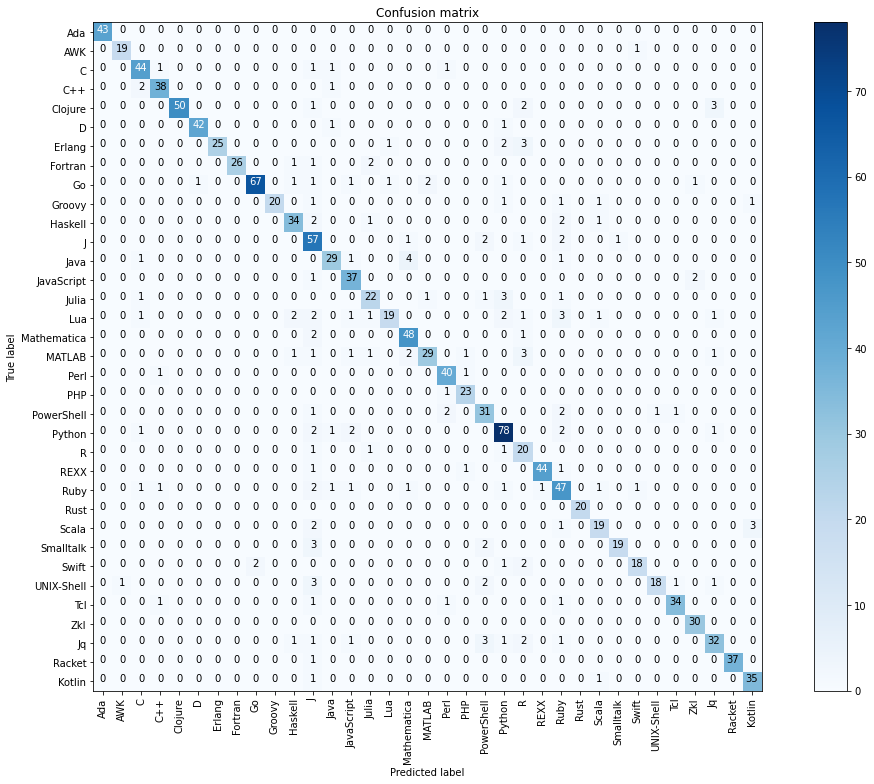

In [52]:
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(15,11))
plot_confusion_matrix(cnf_matrix, classes=lang_map.keys())

## Learning Curves

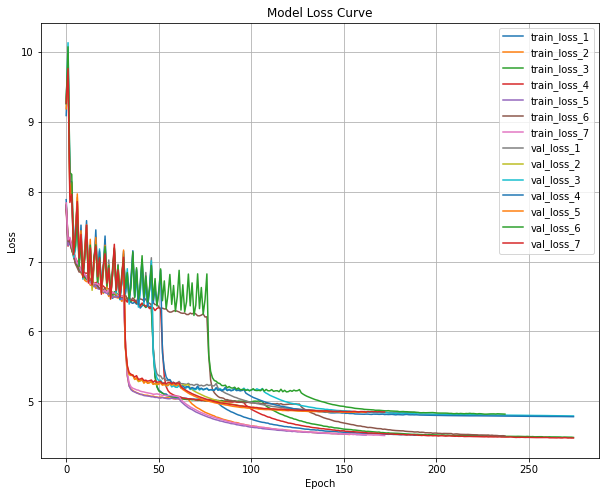

In [53]:
plt.figure(figsize=(10,8))
plt.plot(loss_values["train_loss_1"], label='train_loss_1')
plt.plot(loss_values["train_loss_2"], label='train_loss_2')
plt.plot(loss_values["train_loss_3"], label='train_loss_3')
plt.plot(loss_values["train_loss_4"], label='train_loss_4')
plt.plot(loss_values["train_loss_5"], label='train_loss_5')
plt.plot(loss_values["train_loss_6"], label='train_loss_6')
plt.plot(loss_values["train_loss_7"], label='train_loss_7')
plt.plot(loss_values["val_loss_1"], label='val_loss_1')
plt.plot(loss_values["val_loss_2"], label='val_loss_2')
plt.plot(loss_values["val_loss_3"], label='val_loss_3')
plt.plot(loss_values["val_loss_4"], label='val_loss_4')
plt.plot(loss_values["val_loss_5"], label='val_loss_5')
plt.plot(loss_values["val_loss_6"], label='val_loss_6')
plt.plot(loss_values["val_loss_7"], label='val_loss_7')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

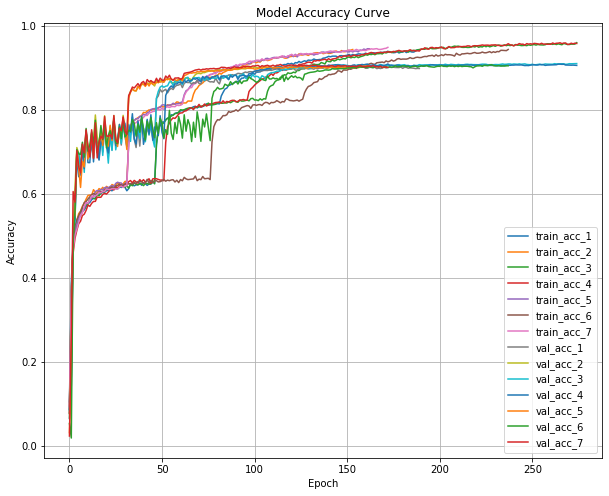

In [55]:
plt.figure(figsize=(10,8))
plt.plot(acc_values["train_acc_1"], label='train_acc_1')
plt.plot(acc_values["train_acc_2"], label='train_acc_2')
plt.plot(acc_values["train_acc_3"], label='train_acc_3')
plt.plot(acc_values["train_acc_4"], label='train_acc_4')
plt.plot(acc_values["train_acc_5"], label='train_acc_5')
plt.plot(acc_values["train_acc_6"], label='train_acc_6')
plt.plot(acc_values["train_acc_7"], label='train_acc_7')
plt.plot(acc_values["val_acc_1"], label='val_acc_1')
plt.plot(acc_values["val_acc_2"], label='val_acc_2')
plt.plot(acc_values["val_acc_3"], label='val_acc_3')
plt.plot(acc_values["val_acc_4"], label='val_acc_4')
plt.plot(acc_values["val_acc_5"], label='val_acc_5')
plt.plot(acc_values["val_acc_6"], label='val_acc_6')
plt.plot(acc_values["val_acc_7"], label='val_acc_7')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Model Accuracy Curve")
plt.legend()
plt.grid()
plt.show()